In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            roc_auc_score, roc_curve, precision_recall_curve, auc)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

✓ Training data loaded: 640 rows, 10 columns
✓ Test data loaded: 200 rows, 10 columns
✓ Validation data loaded: 160 rows, 10 columns

Column names: ['cape', 'cin', 'dewpoint_2m', 'temp_2m', 'tcwv', 'surface_pressure', 'shear_0_1km', 'shear_0_3km', 'ef_class', 'ef_binary']

--------------------------------------------------------------------------------
TRAINING DATA INFO:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cape              640 non-null    float64
 1   cin               295 non-null    float64
 2   dewpoint_2m       640 non-null    float64
 3   temp_2m           640 non-null    float64
 4   tcwv              640 non-null    float64
 5   surface_pressure  640 non-null    float64
 6   shear_0_1km       640 non-null    float64
 7   shear_0_3km

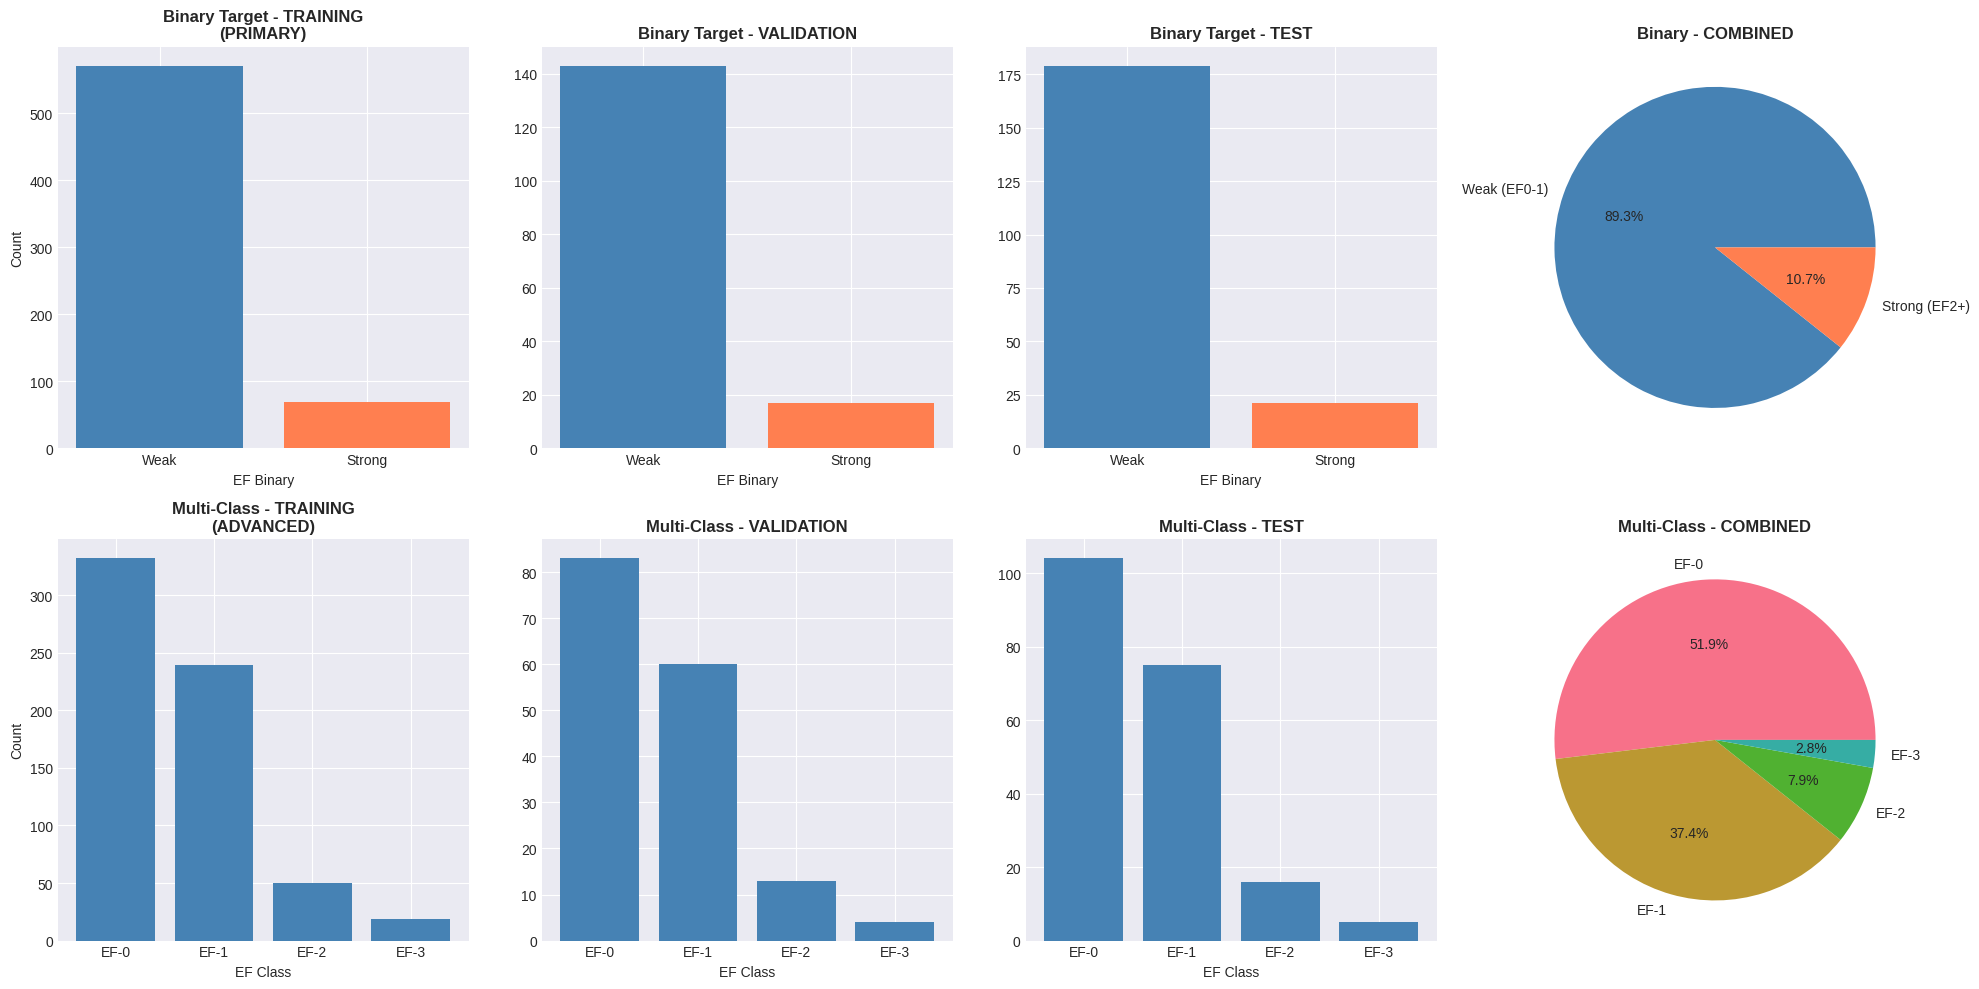

In [84]:
# ============================================================================
# STEP 2: LOAD AND EXPLORE DATA
# ============================================================================

# Data paths
TRAIN_FILE = '/content/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '/content/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALIDATION_FILE = '/content/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
print(f"✓ Training data loaded: {df_train.shape[0]} rows, {df_train.shape[1]} columns")

# Load test data
df_test = pd.read_excel(TEST_FILE)
print(f"✓ Test data loaded: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

# Load validation data
df_validation = pd.read_excel(VALIDATION_FILE)
print(f"✓ Validation data loaded: {df_validation.shape[0]} rows, {df_validation.shape[1]} columns")

# Basic information
print(f"\nColumn names: {df_train.columns.tolist()}")

print("\n" + "-" * 80)
print("TRAINING DATA INFO:")
print("-" * 80)
print(df_train.info())

print("\n" + "-" * 80)
print("STATISTICAL SUMMARY (TRAINING):")
print("-" * 80)
print(df_train.describe())

print("\n" + "-" * 80)
print("MISSING VALUES:")
print("-" * 80)
missing_train = df_train.isnull().sum()
missing_train = missing_train[missing_train > 0]
if len(missing_train) > 0:
    print("Training set:")
    print(missing_train)
else:
    print("Training set: No missing values")

missing_test = df_test.isnull().sum()
missing_test = missing_test[missing_test > 0]
if len(missing_test) > 0:
    print("\nTest set:")
    print(missing_test)
else:
    print("\nTest set: No missing values")

missing_validation = df_validation.isnull().sum()
missing_validation = missing_validation[missing_validation > 0]
if len(missing_validation) > 0:
    print("\nValidation set:")
    print(missing_validation)
else:
    print("\nValidation set: No missing values")

# Target distributions
print("\n" + "-" * 80)
print("TARGET DISTRIBUTIONS:")
print("-" * 80)
print("\nBINARY (PRIMARY CHALLENGE) - Training:")
print(df_train['ef_binary'].value_counts().sort_index())
print(f"Imbalance ratio: {df_train['ef_binary'].value_counts()[0] / df_train['ef_binary'].value_counts()[1]:.2f}:1")

print("\nBINARY - Validation:")
print(df_validation['ef_binary'].value_counts().sort_index())

print("\nBINARY - Test:")
print(df_test['ef_binary'].value_counts().sort_index())

print("\nMULTI-CLASS (ADVANCED) - Training:")
print(df_train['ef_class'].value_counts().sort_index())

print("\nMULTI-CLASS - Validation:")
print(df_validation['ef_class'].value_counts().sort_index())

print("\nMULTI-CLASS - Test:")
print(df_test['ef_class'].value_counts().sort_index())

# Visualize distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Binary - Training
axes[0, 0].bar([0, 1], df_train['ef_binary'].value_counts().sort_index(),
               color=['steelblue', 'coral'])
axes[0, 0].set_title('Binary Target - TRAINING\n(PRIMARY)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('EF Binary')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Weak', 'Strong'])

# Binary - Validation
axes[0, 1].bar([0, 1], df_validation['ef_binary'].value_counts().sort_index(),
               color=['steelblue', 'coral'])
axes[0, 1].set_title('Binary Target - VALIDATION', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('EF Binary')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Weak', 'Strong'])

# Binary - Test
axes[0, 2].bar([0, 1], df_test['ef_binary'].value_counts().sort_index(),
               color=['steelblue', 'coral'])
axes[0, 2].set_title('Binary Target - TEST', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('EF Binary')
axes[0, 2].set_xticks([0, 1])
axes[0, 2].set_xticklabels(['Weak', 'Strong'])

# Binary - Combined pie
combined_binary = pd.concat([df_train['ef_binary'], df_validation['ef_binary'], df_test['ef_binary']])
axes[0, 3].pie(combined_binary.value_counts().sort_index(),
               labels=['Weak (EF0-1)', 'Strong (EF2+)'],
               autopct='%1.1f%%', colors=['steelblue', 'coral'])
axes[0, 3].set_title('Binary - COMBINED', fontsize=12, fontweight='bold')

# Multi-class - Training
axes[1, 0].bar(range(4), df_train['ef_class'].value_counts().sort_index(), color='steelblue')
axes[1, 0].set_title('Multi-Class - TRAINING\n(ADVANCED)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('EF Class')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticks(range(4))
axes[1, 0].set_xticklabels([f'EF-{i}' for i in range(4)])

# Multi-class - Validation
axes[1, 1].bar(range(4), df_validation['ef_class'].value_counts().sort_index(), color='steelblue')
axes[1, 1].set_title('Multi-Class - VALIDATION', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('EF Class')
axes[1, 1].set_xticks(range(4))
axes[1, 1].set_xticklabels([f'EF-{i}' for i in range(4)])

# Multi-class - Test
axes[1, 2].bar(range(4), df_test['ef_class'].value_counts().sort_index(), color='steelblue')
axes[1, 2].set_title('Multi-Class - TEST', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('EF Class')
axes[1, 2].set_xticks(range(4))
axes[1, 2].set_xticklabels([f'EF-{i}' for i in range(4)])

# Multi-class - Combined pie
combined_class = pd.concat([df_train['ef_class'], df_validation['ef_class'], df_test['ef_class']])
axes[1, 3].pie(combined_class.value_counts().sort_index(),
               labels=[f'EF-{i}' for i in range(4)], autopct='%1.1f%%')
axes[1, 3].set_title('Multi-Class - COMBINED', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [85]:
# ============================================================================
# DATA CLEANING: Remove leading apostrophes and convert to numeric
# ============================================================================
print("\n" + "=" * 80)
print("DATA CLEANING: Checking for text-formatted numbers")
print("=" * 80)

def clean_numeric_columns(df):
    """Remove leading apostrophes and convert to numeric"""
    cleaned_cols = []
    for col in df.columns:
        if col not in ['ef_class', 'ef_binary']:  # Skip target columns
            # Check if column is object/string type
            if df[col].dtype == 'object':
                # Try to remove leading apostrophe and convert to numeric
                df[col] = df[col].astype(str).str.lstrip("'")
                df[col] = pd.to_numeric(df[col], errors='coerce')
                cleaned_cols.append(col)
    return df, cleaned_cols

# Clean all datasets
df_train, cleaned_train = clean_numeric_columns(df_train)
df_test, cleaned_test = clean_numeric_columns(df_test)
df_validation, cleaned_validation = clean_numeric_columns(df_validation)

if cleaned_train:
    print(f"✓ Cleaned {len(cleaned_train)} columns in training data")
if cleaned_validation:
    print(f"✓ Cleaned {len(cleaned_validation)} columns in validation data")
if cleaned_test:
    print(f"✓ Cleaned {len(cleaned_test)} columns in test data")

# Verify data types
print("\n" + "-" * 80)
print("DATA TYPES AFTER CLEANING:")
print("-" * 80)
print(df_train.dtypes)



DATA CLEANING: Checking for text-formatted numbers

--------------------------------------------------------------------------------
DATA TYPES AFTER CLEANING:
--------------------------------------------------------------------------------
cape                float64
cin                 float64
dewpoint_2m         float64
temp_2m             float64
tcwv                float64
surface_pressure    float64
shear_0_1km         float64
shear_0_3km         float64
ef_class              int64
ef_binary             int64
dtype: object


In [86]:
# ============================================================================
# STEP 3: DATA PREPROCESSING
# ============================================================================

# Separate features and targets
X_train = df_train.drop(['ef_class', 'ef_binary'], axis=1, errors='ignore')
X_validation = df_validation.drop(['ef_class', 'ef_binary'], axis=1, errors='ignore')
X_test = df_test.drop(['ef_class', 'ef_binary'], axis=1, errors='ignore')

y_train_binary = df_train['ef_binary']
y_validation_binary = df_validation['ef_binary']
y_test_binary = df_test['ef_binary']

y_train_class = df_train['ef_class']
y_validation_class = df_validation['ef_class']
y_test_class = df_test['ef_class']

print(f"\nOriginal features shape:")
print(f"  Training:   {X_train.shape}")
print(f"  Validation: {X_validation.shape}")
print(f"  Test:       {X_test.shape}")

# ============================================================================
# IMPROVED IMPUTATION STRATEGY
# ============================================================================
def smart_impute_tornado_data(df_train, df_validation, df_test):
    """
    Impute missing values intelligently based on data characteristics
    Returns: imputed train, validation, and test dataframes
    """
    # Make copies to avoid modifying original data
    df_train = df_train.copy()
    df_validation = df_validation.copy()
    df_test = df_test.copy()

    # Create missing indicator for CIN (BEFORE imputation)
    df_train['cin_missing'] = df_train['cin'].isna().astype(int)
    df_validation['cin_missing'] = df_validation['cin'].isna().astype(int)
    df_test['cin_missing'] = df_test['cin'].isna().astype(int)

    print(f"\nCIN Missing Values:")
    print(f"  Train:      {df_train['cin'].isna().sum()} ({df_train['cin'].isna().sum()/len(df_train)*100:.1f}%)")
    print(f"  Validation: {df_validation['cin'].isna().sum()} ({df_validation['cin'].isna().sum()/len(df_validation)*100:.1f}%)")
    print(f"  Test:       {df_test['cin'].isna().sum()} ({df_test['cin'].isna().sum()/len(df_test)*100:.1f}%)")

    # Conditional imputation for CIN based on CAPE
    # Strategy: Low CAPE (<100) -> CIN = 0 (no significant convection)
    low_cape_mask_train = (df_train['cin'].isna()) & (df_train['cape'] < 100)
    low_cape_count_train = low_cape_mask_train.sum()
    df_train.loc[low_cape_mask_train, 'cin'] = 0

    low_cape_mask_validation = (df_validation['cin'].isna()) & (df_validation['cape'] < 100)
    low_cape_count_validation = low_cape_mask_validation.sum()
    df_validation.loc[low_cape_mask_validation, 'cin'] = 0

    low_cape_mask_test = (df_test['cin'].isna()) & (df_test['cape'] < 100)
    low_cape_count_test = low_cape_mask_test.sum()
    df_test.loc[low_cape_mask_test, 'cin'] = 0

    # Strategy: High CAPE (>=100) -> use median of high-CAPE cases FROM TRAINING DATA
    high_cape_cin_median = df_train[(df_train['cape'] >= 100) &
                                     (df_train['cin'].notna())]['cin'].median()

    high_cape_mask_train = (df_train['cin'].isna()) & (df_train['cape'] >= 100)
    high_cape_count_train = high_cape_mask_train.sum()
    df_train.loc[high_cape_mask_train, 'cin'] = high_cape_cin_median

    high_cape_mask_validation = (df_validation['cin'].isna()) & (df_validation['cape'] >= 100)
    high_cape_count_validation = high_cape_mask_validation.sum()
    df_validation.loc[high_cape_mask_validation, 'cin'] = high_cape_cin_median

    high_cape_mask_test = (df_test['cin'].isna()) & (df_test['cape'] >= 100)
    high_cape_count_test = high_cape_mask_test.sum()
    df_test.loc[high_cape_mask_test, 'cin'] = high_cape_cin_median

    print(f"\nImputation Summary:")
    print(f"  Train      - Low CAPE (CIN=0):     {low_cape_count_train}")
    print(f"  Train      - High CAPE (CIN={high_cape_cin_median:.2f}): {high_cape_count_train}")
    print(f"  Validation - Low CAPE (CIN=0):     {low_cape_count_validation}")
    print(f"  Validation - High CAPE (CIN={high_cape_cin_median:.2f}): {high_cape_count_validation}")
    print(f"  Test       - Low CAPE (CIN=0):     {low_cape_count_test}")
    print(f"  Test       - High CAPE (CIN={high_cape_cin_median:.2f}): {high_cape_count_test}")

    # Handle any remaining missing values in other features (safety check)
    # IMPORTANT: Use TRAINING statistics for all datasets
    for col in df_train.columns:
        if col != 'cin_missing' and df_train[col].isna().any():
            median_val = df_train[col].median()
            df_train[col].fillna(median_val, inplace=True)
            df_validation[col].fillna(median_val, inplace=True)
            df_test[col].fillna(median_val, inplace=True)
            print(f"  Filled {col} with training median: {median_val:.2f}")

    # Verify no missing values remain
    assert df_train.isna().sum().sum() == 0, "Training data still has missing values!"
    assert df_validation.isna().sum().sum() == 0, "Validation data still has missing values!"
    assert df_test.isna().sum().sum() == 0, "Test data still has missing values!"
    print(f"\n✓ Imputation complete - no missing values remain")

    return df_train, df_validation, df_test

# Apply smart imputation
X_train_imputed, X_validation_imputed, X_test_imputed = smart_impute_tornado_data(
    X_train, X_validation, X_test
)

print(f"\nAfter imputation shape:")
print(f"  Training:   {X_train_imputed.shape}")
print(f"  Validation: {X_validation_imputed.shape}")
print(f"  Test:       {X_test_imputed.shape}")




Original features shape:
  Training:   (640, 8)
  Validation: (160, 8)
  Test:       (200, 8)

CIN Missing Values:
  Train:      345 (53.9%)
  Validation: 95 (59.4%)
  Test:       106 (53.0%)

Imputation Summary:
  Train      - Low CAPE (CIN=0):     290
  Train      - High CAPE (CIN=190.06): 55
  Validation - Low CAPE (CIN=0):     85
  Validation - High CAPE (CIN=190.06): 10
  Test       - Low CAPE (CIN=0):     90
  Test       - High CAPE (CIN=190.06): 16

✓ Imputation complete - no missing values remain

After imputation shape:
  Training:   (640, 9)
  Validation: (160, 9)
  Test:       (200, 9)


In [87]:
# ============================================================================
# NORMALIZE FEATURES
# ============================================================================

# For tornado data with right-skewed distributions, MinMaxScaler is better
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit ONLY on training data, transform all datasets
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_validation_scaled = scaler.transform(X_validation_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert back to DataFrame to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
X_validation_scaled = pd.DataFrame(X_validation_scaled, columns=X_validation_imputed.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

print(f"\n✓ Normalization complete")
print(f"  Scaled range: [{X_train_scaled.min().min():.3f}, {X_train_scaled.max().max():.3f}]")
print(f"  Final shapes:")
print(f"    Training:   {X_train_scaled.shape}")
print(f"    Validation: {X_validation_scaled.shape}")
print(f"    Test:       {X_test_scaled.shape}")

# Verify the cin_missing feature distribution
print(f"\nCIN missing indicator distribution:")
print(f"  Train:      {X_train_scaled['cin_missing'].value_counts().to_dict()}")
print(f"  Validation: {X_validation_scaled['cin_missing'].value_counts().to_dict()}")
print(f"  Test:       {X_test_scaled['cin_missing'].value_counts().to_dict()}")

# ============================================================================
# EXPORT NORMALIZED DATASETS
# ============================================================================
print("\n" + "=" * 80)
print("EXPORTING NORMALIZED DATASETS")
print("=" * 80)

# Define output paths
X_TRAIN_SCALED_FILE = '/content/X_train_scaled.csv'
X_VALIDATION_SCALED_FILE = '/content/X_validation_scaled.csv'
X_TEST_SCALED_FILE = '/content/X_test_scaled.csv'

# Export to CSV
try:
    X_train_scaled.to_csv(X_TRAIN_SCALED_FILE, index=False)
    print(f"✓ Normalized training data exported to: {X_TRAIN_SCALED_FILE}")
except Exception as e:
    print(f"✗ Error exporting training data: {e}")

try:
    X_validation_scaled.to_csv(X_VALIDATION_SCALED_FILE, index=False)
    print(f"✓ Normalized validation data exported to: {X_VALIDATION_SCALED_FILE}")
except Exception as e:
    print(f"✗ Error exporting validation data: {e}")

try:
    X_test_scaled.to_csv(X_TEST_SCALED_FILE, index=False)
    print(f"✓ Normalized test data exported to: {X_TEST_SCALED_FILE}")
except Exception as e:
    print(f"✗ Error exporting test data: {e}")



✓ Normalization complete
  Scaled range: [0.000, 1.000]
  Final shapes:
    Training:   (640, 9)
    Validation: (160, 9)
    Test:       (200, 9)

CIN missing indicator distribution:
  Train:      {1.0: 345, 0.0: 295}
  Validation: {1.0: 95, 0.0: 65}
  Test:       {1.0: 106, 0.0: 94}

EXPORTING NORMALIZED DATASETS
✓ Normalized training data exported to: /content/X_train_scaled.csv
✓ Normalized validation data exported to: /content/X_validation_scaled.csv
✓ Normalized test data exported to: /content/X_test_scaled.csv



STEP 4: CORRELATION ANALYSIS


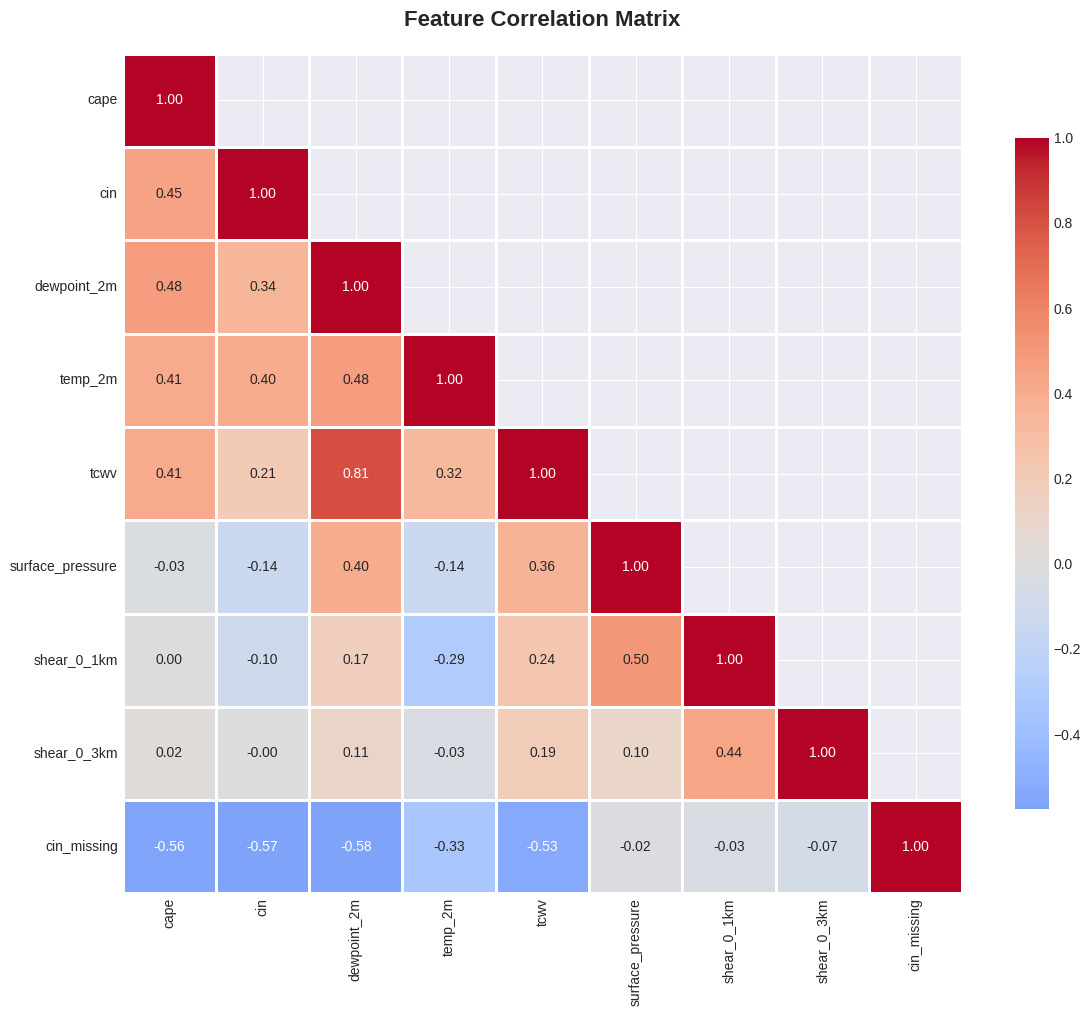


STEP 5: PRINCIPAL COMPONENT ANALYSIS (PCA)

Variance Explained by Components:
PC1: 59.41% (Cumulative: 59.41%)
PC2: 16.06% (Cumulative: 75.47%)
PC3: 7.52% (Cumulative: 82.99%)
PC4: 5.77% (Cumulative: 88.76%)
PC5: 4.66% (Cumulative: 93.42%)
PC6: 2.32% (Cumulative: 95.73%)
PC7: 1.81% (Cumulative: 97.55%)
PC8: 1.58% (Cumulative: 99.13%)
PC9: 0.87% (Cumulative: 100.00%)


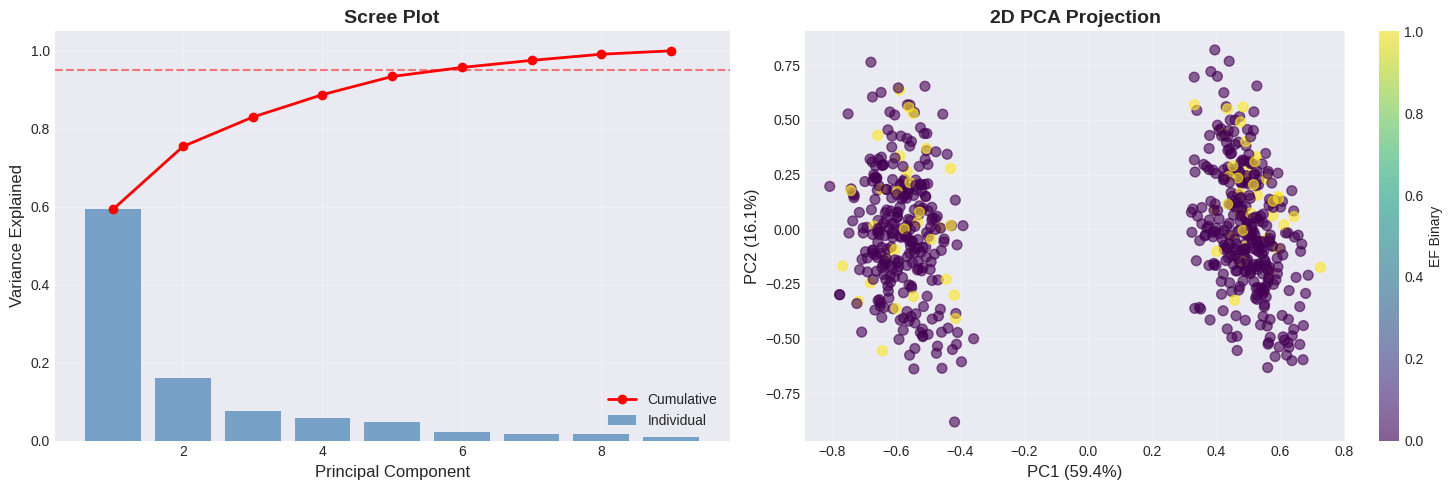

In [88]:
# ============================================================================
# STEP 4: CORRELATION MATRIX
# ============================================================================
print("\n" + "=" * 80)
print("STEP 4: CORRELATION ANALYSIS")
print("=" * 80)

correlation_matrix = X_train_scaled.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, mask=mask)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ============================================================================
# STEP 5: PCA ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("STEP 5: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("=" * 80)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print("\nVariance Explained by Components:")
for i, (var, cum_var) in enumerate(zip(variance_explained, cumulative_variance)):
    print(f"PC{i+1}: {var*100:.2f}% (Cumulative: {cum_var*100:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot
axes[0].bar(range(1, len(variance_explained)+1), variance_explained, alpha=0.7,
            color='steelblue', label='Individual')
axes[0].plot(range(1, len(variance_explained)+1), cumulative_variance,
             'ro-', linewidth=2, label='Cumulative')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Variance Explained', fontsize=12)
axes[0].set_title('Scree Plot', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].axhline(y=0.95, color='red', linestyle='--', alpha=0.5)

# 2D PCA
scatter = axes[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1],
                         c=y_train_binary, cmap='viridis', alpha=0.6, s=50)
axes[1].set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)', fontsize=12)
axes[1].set_title('2D PCA Projection', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='EF Binary')

plt.tight_layout()
plt.show()



STEP 6A: BINARY CLASSIFICATION - PRIMARY CHALLENGE

Applying SMOTE for binary classification...
✓ Training samples: 640 → 1142
  Class 0: 571
  Class 1: 571

--------------------------------------------------------------------------------
TRAINING BINARY CLASSIFICATION MODELS:
--------------------------------------------------------------------------------

Training: Logistic Regression
  CV ROC AUC: 0.7004 (±0.0185)
  Validation ROC AUC: 0.6067 | Accuracy: 0.5938
  Test ROC AUC: 0.6919 | Accuracy: 0.5950

Training: Random Forest
  CV ROC AUC: 0.9196 (±0.0100)
  Validation ROC AUC: 0.5019 | Accuracy: 0.7438
  Test ROC AUC: 0.6773 | Accuracy: 0.6900

Training: Gradient Boosting
  CV ROC AUC: 0.9437 (±0.0098)
  Validation ROC AUC: 0.5171 | Accuracy: 0.7937
  Test ROC AUC: 0.6829 | Accuracy: 0.7850

Training: XGBoost
  CV ROC AUC: 0.9364 (±0.0137)
  Validation ROC AUC: 0.4636 | Accuracy: 0.7688
  Test ROC AUC: 0.6318 | Accuracy: 0.7700

STEP 7A: BINARY CLASSIFICATION EVALUATION

MODEL CO

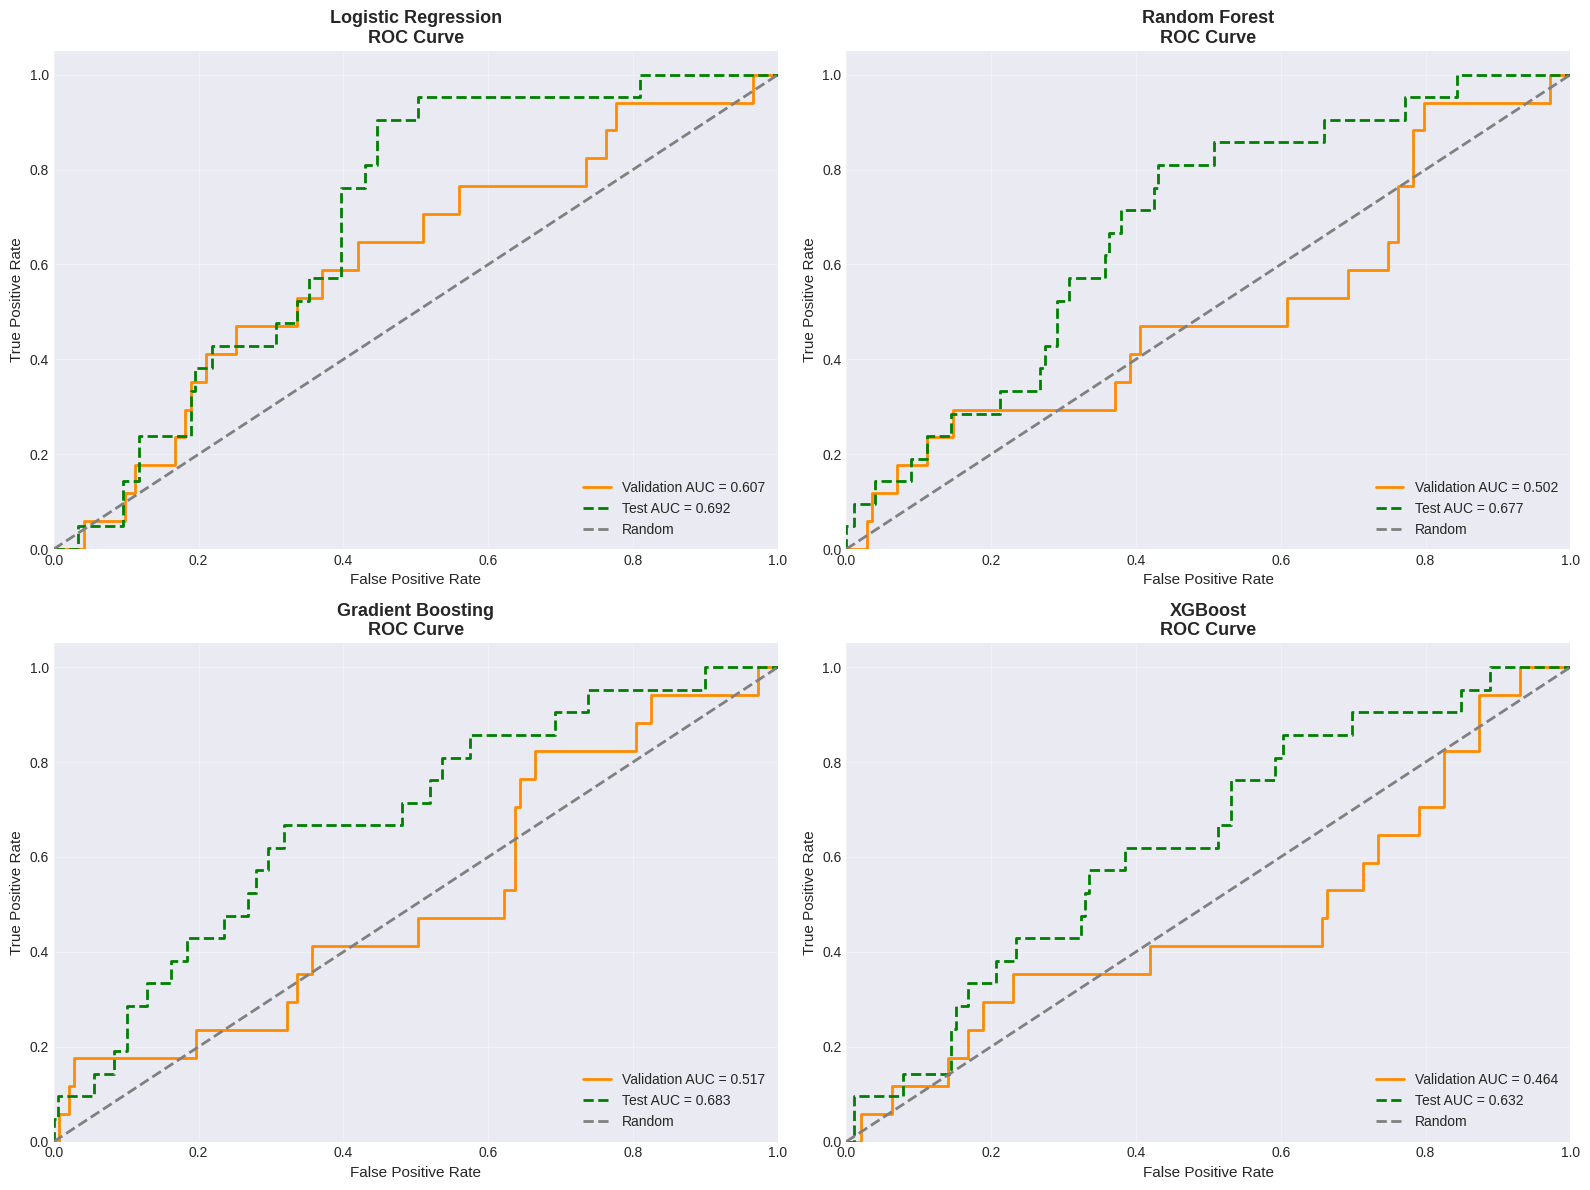

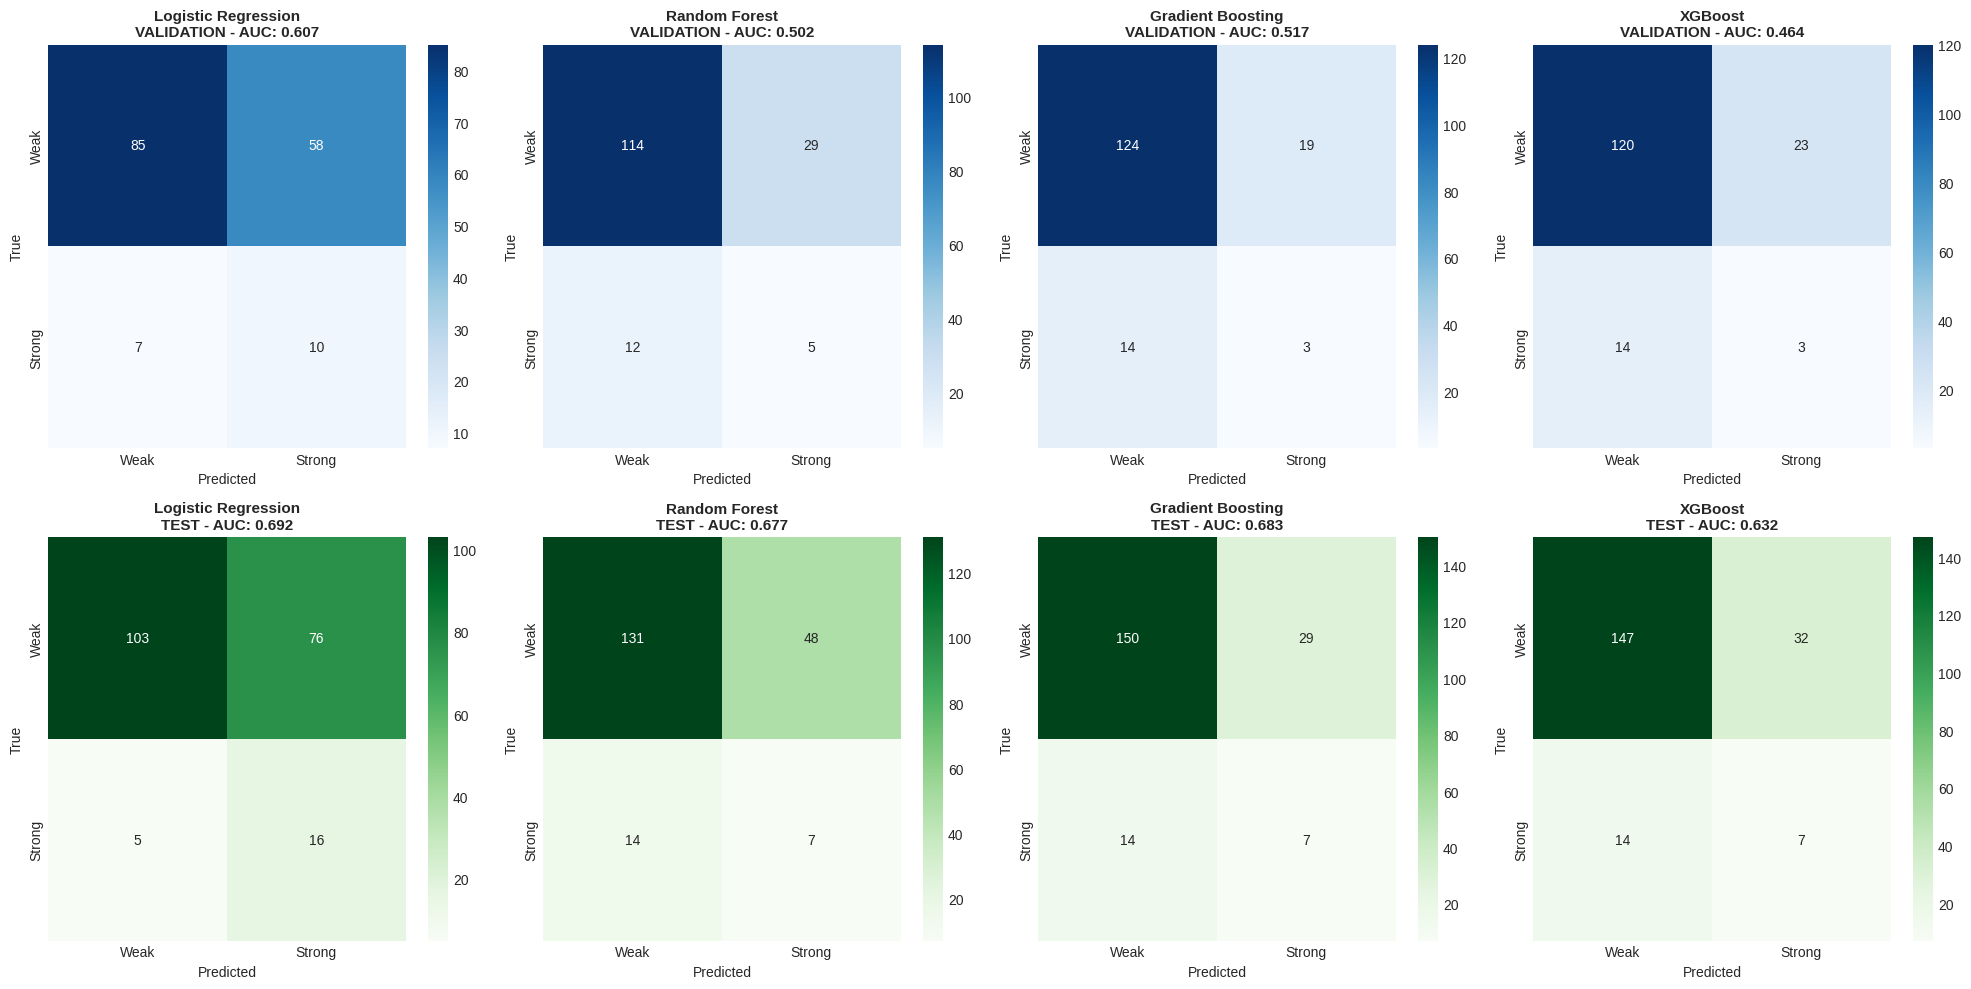


STEP 6B: MULTI-CLASS CLASSIFICATION - ADVANCED CHALLENGE

Applying SMOTE for multi-class classification...
✓ Training samples: 640 → 1328
  Class 0: 332
  Class 1: 332
  Class 2: 332
  Class 3: 332

--------------------------------------------------------------------------------
TRAINING MULTI-CLASS CLASSIFICATION MODELS:
--------------------------------------------------------------------------------

Training: Logistic Regression
  CV Accuracy: 0.3675 (±0.0414)
  Validation Accuracy: 0.4437
  Test Accuracy: 0.3750

Training: Random Forest
  CV Accuracy: 0.6800 (±0.0241)
  Validation Accuracy: 0.5375
  Test Accuracy: 0.4550

Training: Gradient Boosting
  CV Accuracy: 0.7108 (±0.0232)
  Validation Accuracy: 0.5687
  Test Accuracy: 0.5400

Training: XGBoost
  CV Accuracy: 0.7101 (±0.0334)
  Validation Accuracy: 0.5312
  Test Accuracy: 0.5250

STEP 7B: MULTI-CLASS CLASSIFICATION EVALUATION

MODEL COMPARISON:
                      cv_mean validation_accuracy test_accuracy
Logistic Regres

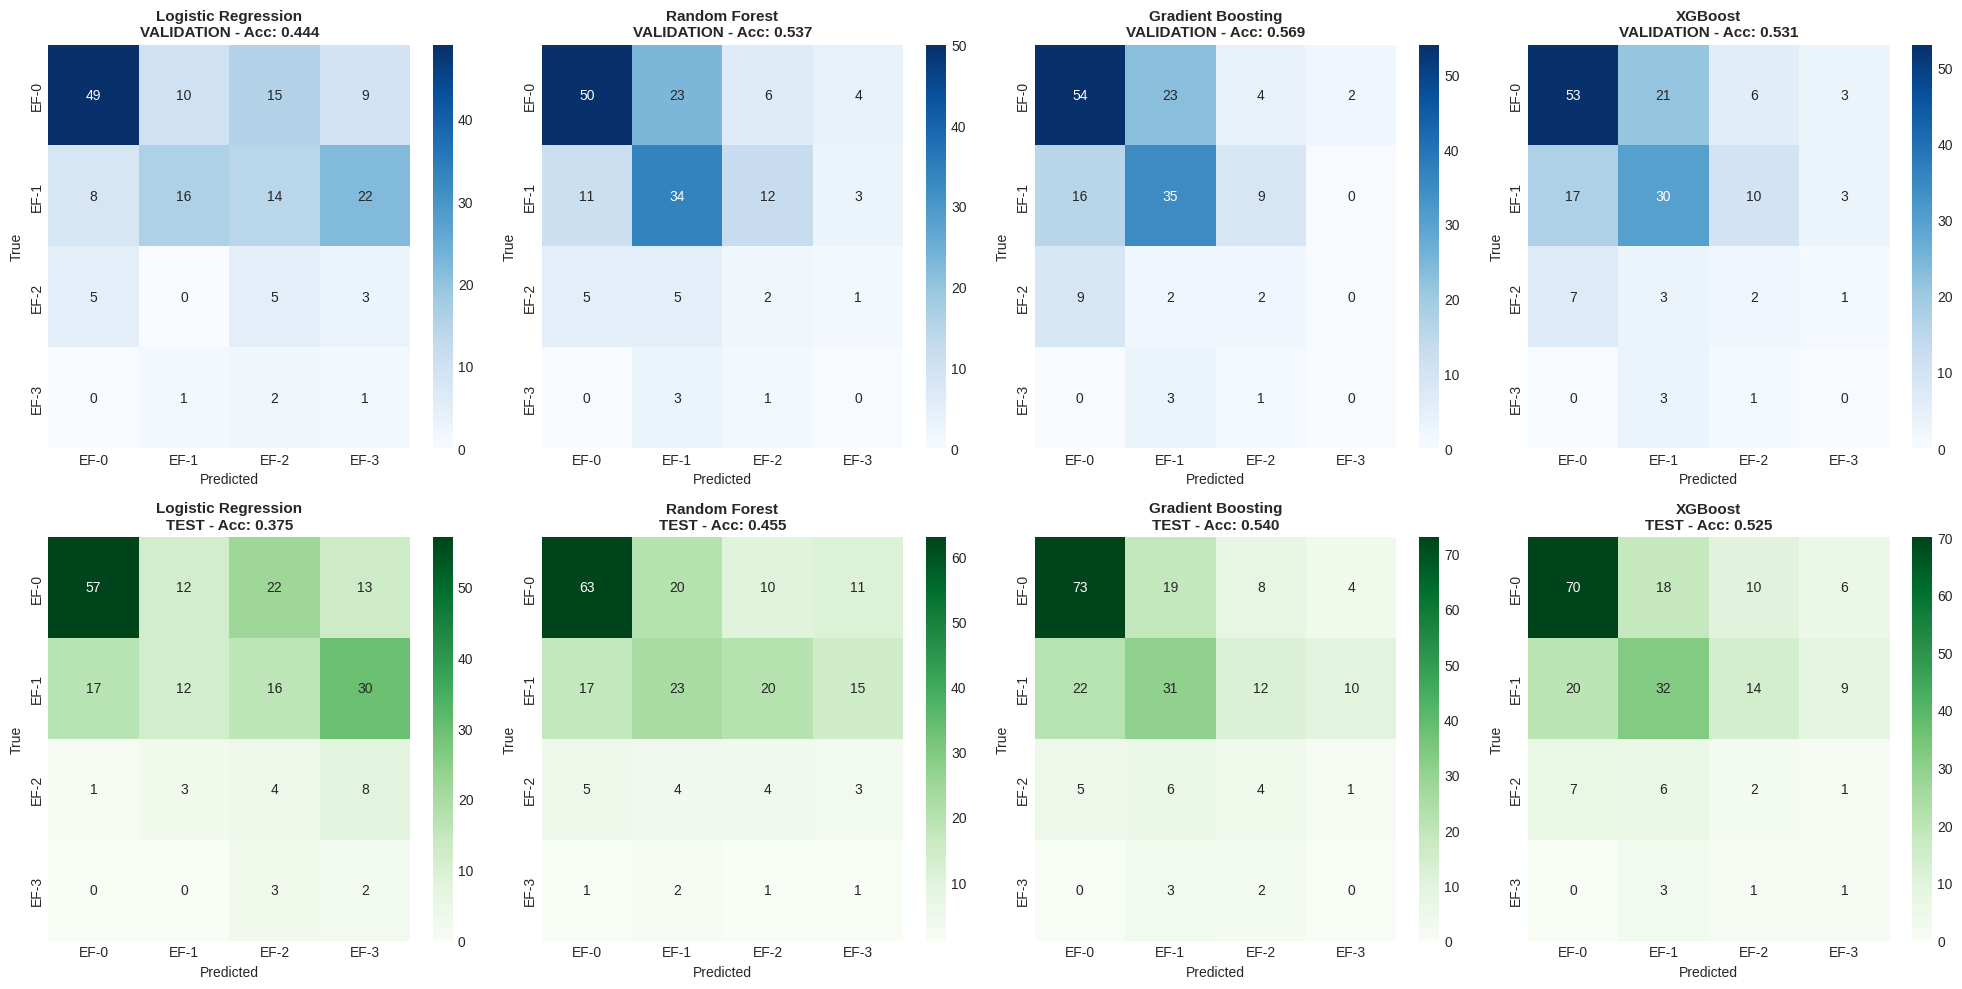


ANALYSIS COMPLETE!

Binary Classification Best Model: Logistic Regression
  Validation ROC AUC: 0.6067
  Test ROC AUC: 0.6919

Multi-Class Classification Best Model: Gradient Boosting
  Validation Accuracy: 0.5687
  Test Accuracy: 0.5400


In [89]:
# ============================================================================
# STEP 6A: BINARY CLASSIFICATION (PRIMARY CHALLENGE)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 6A: BINARY CLASSIFICATION - PRIMARY CHALLENGE")
print("=" * 80)

# Apply SMOTE for binary classification
print("\nApplying SMOTE for binary classification...")
smote_binary = SMOTE(random_state=42)
X_train_balanced_binary, y_train_balanced_binary = smote_binary.fit_resample(
    X_train_scaled, y_train_binary
)
print(f"✓ Training samples: {len(y_train_binary)} → {len(y_train_balanced_binary)}")
print(f"  Class 0: {(y_train_balanced_binary == 0).sum()}")
print(f"  Class 1: {(y_train_balanced_binary == 1).sum()}")

# Define models
models_binary = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced', solver='lbfgs'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4,
        random_state=42, class_weight='balanced', n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        min_samples_split=10, min_samples_leaf=4, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42,
        eval_metric='logloss', use_label_encoder=False
    )
}

results_binary = {}
trained_models_binary = {}

print("\n" + "-" * 80)
print("TRAINING BINARY CLASSIFICATION MODELS:")
print("-" * 80)

for name, model in models_binary.items():
    print(f"\nTraining: {name}")

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_balanced_binary, y_train_balanced_binary,
                                cv=cv, scoring='roc_auc', n_jobs=-1)

    # Train model
    model.fit(X_train_balanced_binary, y_train_balanced_binary)

    # Predictions on all datasets
    y_train_pred = model.predict(X_train_scaled)
    y_validation_pred = model.predict(X_validation_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Probabilities
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
        y_validation_proba = model.predict_proba(X_validation_scaled)[:, 1]
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_train_proba = model.decision_function(X_train_scaled)
        y_validation_proba = model.decision_function(X_validation_scaled)
        y_test_proba = model.decision_function(X_test_scaled)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train_binary, y_train_pred)
    validation_accuracy = accuracy_score(y_validation_binary, y_validation_pred)
    test_accuracy = accuracy_score(y_test_binary, y_test_pred)

    train_roc_auc = roc_auc_score(y_train_binary, y_train_proba)
    validation_roc_auc = roc_auc_score(y_validation_binary, y_validation_proba)
    test_roc_auc = roc_auc_score(y_test_binary, y_test_proba)

    results_binary[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_accuracy': train_accuracy,
        'validation_accuracy': validation_accuracy,
        'test_accuracy': test_accuracy,
        'train_roc_auc': train_roc_auc,
        'validation_roc_auc': validation_roc_auc,
        'test_roc_auc': test_roc_auc,
        'y_validation_pred': y_validation_pred,
        'y_test_pred': y_test_pred,
        'y_validation_proba': y_validation_proba,
        'y_test_proba': y_test_proba
    }

    trained_models_binary[name] = model

    print(f"  CV ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Validation ROC AUC: {validation_roc_auc:.4f} | Accuracy: {validation_accuracy:.4f}")
    print(f"  Test ROC AUC: {test_roc_auc:.4f} | Accuracy: {test_accuracy:.4f}")

# ============================================================================
# STEP 7A: BINARY CLASSIFICATION EVALUATION
# ============================================================================
print("\n" + "=" * 80)
print("STEP 7A: BINARY CLASSIFICATION EVALUATION")
print("=" * 80)

results_df_binary = pd.DataFrame(results_binary).T
print("\nMODEL COMPARISON:")
print(results_df_binary[['cv_mean', 'validation_roc_auc', 'test_roc_auc',
                          'validation_accuracy', 'test_accuracy']].round(4))

best_model_name_binary = results_df_binary['validation_roc_auc'].idxmax()
best_roc_auc_binary = results_df_binary.loc[best_model_name_binary, 'validation_roc_auc']

print(f"\n🏆 BEST MODEL (by Validation ROC AUC): {best_model_name_binary}")
print(f"   Validation ROC AUC: {best_roc_auc_binary:.4f}")
print(f"   Test ROC AUC: {results_df_binary.loc[best_model_name_binary, 'test_roc_auc']:.4f}")

# Classification reports
print("\n" + "-" * 80)
print(f"CLASSIFICATION REPORT - {best_model_name_binary} (VALIDATION):")
print("-" * 80)
y_pred_best_val = results_binary[best_model_name_binary]['y_validation_pred']
print(classification_report(y_validation_binary, y_pred_best_val,
                          target_names=['Weak (EF0-1)', 'Strong (EF2+)'], digits=4))

print("\n" + "-" * 80)
print(f"CLASSIFICATION REPORT - {best_model_name_binary} (TEST):")
print("-" * 80)
y_pred_best_test = results_binary[best_model_name_binary]['y_test_pred']
print(classification_report(y_test_binary, y_pred_best_test,
                          target_names=['Weak (EF0-1)', 'Strong (EF2+)'], digits=4))

# ROC Curves for Validation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results_binary.items()):
    fpr, tpr, _ = roc_curve(y_validation_binary, result['y_validation_proba'])
    roc_auc = result['validation_roc_auc']

    axes[idx].plot(fpr, tpr, color='darkorange', lw=2, label=f'Validation AUC = {roc_auc:.3f}')

    # Add test curve for comparison
    fpr_test, tpr_test, _ = roc_curve(y_test_binary, result['y_test_proba'])
    roc_auc_test = result['test_roc_auc']
    axes[idx].plot(fpr_test, tpr_test, color='green', lw=2, linestyle='--',
                   label=f'Test AUC = {roc_auc_test:.3f}')

    axes[idx].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel('False Positive Rate', fontsize=11)
    axes[idx].set_ylabel('True Positive Rate', fontsize=11)
    axes[idx].set_title(f'{name}\nROC Curve', fontsize=13, fontweight='bold')
    axes[idx].legend(loc="lower right")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (name, result) in enumerate(results_binary.items()):
    # Validation confusion matrix
    cm_val = confusion_matrix(y_validation_binary, result['y_validation_pred'])
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0, idx],
                xticklabels=['Weak', 'Strong'], yticklabels=['Weak', 'Strong'])

    axes[0, idx].set_title(f'{name}\nVALIDATION - AUC: {result["validation_roc_auc"]:.3f}',
                           fontsize=11, fontweight='bold')
    axes[0, idx].set_xlabel('Predicted', fontsize=10)
    axes[0, idx].set_ylabel('True', fontsize=10)

    # Test confusion matrix
    cm_test = confusion_matrix(y_test_binary, result['y_test_pred'])
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1, idx],
                xticklabels=['Weak', 'Strong'], yticklabels=['Weak', 'Strong'])

    axes[1, idx].set_title(f'{name}\nTEST - AUC: {result["test_roc_auc"]:.3f}',
                          fontsize=11, fontweight='bold')
    axes[1, idx].set_xlabel('Predicted', fontsize=10)
    axes[1, idx].set_ylabel('True', fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# STEP 6B: MULTI-CLASS CLASSIFICATION (ADVANCED CHALLENGE)
# ============================================================================
print("\n" + "=" * 80)
print("STEP 6B: MULTI-CLASS CLASSIFICATION - ADVANCED CHALLENGE")
print("=" * 80)

# Apply SMOTE for multi-class
print("\nApplying SMOTE for multi-class classification...")
smote_class = SMOTE(random_state=42)
X_train_balanced_class, y_train_balanced_class = smote_class.fit_resample(
    X_train_scaled, y_train_class
)
print(f"✓ Training samples: {len(y_train_class)} → {len(y_train_balanced_class)}")
for cls in sorted(pd.Series(y_train_balanced_class).unique()):
    print(f"  Class {cls}: {(y_train_balanced_class == cls).sum()}")

# Define models
models_class = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced',
        multi_class='multinomial', solver='lbfgs'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4,
        random_state=42, class_weight='balanced', n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        min_samples_split=10, min_samples_leaf=4, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42,
        eval_metric='mlogloss', use_label_encoder=False
    )
}

results_class = {}
trained_models_class = {}

print("\n" + "-" * 80)
print("TRAINING MULTI-CLASS CLASSIFICATION MODELS:")
print("-" * 80)

for name, model in models_class.items():
    print(f"\nTraining: {name}")

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_balanced_class, y_train_balanced_class,
                                cv=cv, scoring='accuracy', n_jobs=-1)

    # Train model
    model.fit(X_train_balanced_class, y_train_balanced_class)

    # Predictions
    y_validation_pred = model.predict(X_validation_scaled)
    y_test_pred = model.predict(X_test_scaled)

    validation_accuracy = accuracy_score(y_validation_class, y_validation_pred)
    test_accuracy = accuracy_score(y_test_class, y_test_pred)

    results_class[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'validation_accuracy': validation_accuracy,
        'test_accuracy': test_accuracy,
        'y_validation_pred': y_validation_pred,
        'y_test_pred': y_test_pred
    }

    trained_models_class[name] = model

    print(f"  CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Validation Accuracy: {validation_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")

# ============================================================================
# STEP 7B: MULTI-CLASS CLASSIFICATION EVALUATION
# ============================================================================
print("\n" + "=" * 80)
print("STEP 7B: MULTI-CLASS CLASSIFICATION EVALUATION")
print("=" * 80)

results_df_class = pd.DataFrame(results_class).T
print("\nMODEL COMPARISON:")
print(results_df_class[['cv_mean', 'validation_accuracy', 'test_accuracy']].round(4))

best_model_name_class = results_df_class['validation_accuracy'].idxmax()
best_accuracy_class = results_df_class.loc[best_model_name_class, 'validation_accuracy']

print(f"\n🏆 BEST MODEL (by Validation Accuracy): {best_model_name_class}")
print(f"   Validation Accuracy: {best_accuracy_class:.4f}")
print(f"   Test Accuracy: {results_df_class.loc[best_model_name_class, 'test_accuracy']:.4f}")

# Classification reports
print("\n" + "-" * 80)
print(f"CLASSIFICATION REPORT - {best_model_name_class} (VALIDATION):")
print("-" * 80)
y_pred_best_val_class = results_class[best_model_name_class]['y_validation_pred']
print(classification_report(y_validation_class, y_pred_best_val_class,
                          target_names=[f'EF-{i}' for i in range(4)], digits=4))

print("\n" + "-" * 80)
print(f"CLASSIFICATION REPORT - {best_model_name_class} (TEST):")
print("-" * 80)
y_pred_best_test_class = results_class[best_model_name_class]['y_test_pred']
print(classification_report(y_test_class, y_pred_best_test_class,
                          target_names=[f'EF-{i}' for i in range(4)], digits=4))

# Confusion Matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, (name, result) in enumerate(results_class.items()):
    # Validation confusion matrix
    cm_val = confusion_matrix(y_validation_class, result['y_validation_pred'])
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0, idx],
                xticklabels=[f'EF-{i}' for i in range(4)],
                yticklabels=[f'EF-{i}' for i in range(4)])

    axes[0, idx].set_title(f'{name}\nVALIDATION - Acc: {result["validation_accuracy"]:.3f}',
                          fontsize=11, fontweight='bold')
    axes[0, idx].set_xlabel('Predicted', fontsize=10)
    axes[0, idx].set_ylabel('True', fontsize=10)

    # Test confusion matrix
    cm_test = confusion_matrix(y_test_class, result['y_test_pred'])
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1, idx],
                xticklabels=[f'EF-{i}' for i in range(4)],
                yticklabels=[f'EF-{i}' for i in range(4)])

    axes[1, idx].set_title(f'{name}\nTEST - Acc: {result["test_accuracy"]:.3f}',
                          fontsize=11, fontweight='bold')
    axes[1, idx].set_xlabel('Predicted', fontsize=10)
    axes[1, idx].set_ylabel('True', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print(f"\nBinary Classification Best Model: {best_model_name_binary}")
print(f"  Validation ROC AUC: {results_df_binary.loc[best_model_name_binary, 'validation_roc_auc']:.4f}")
print(f"  Test ROC AUC: {results_df_binary.loc[best_model_name_binary, 'test_roc_auc']:.4f}")

print(f"\nMulti-Class Classification Best Model: {best_model_name_class}")
print(f"  Validation Accuracy: {results_df_class.loc[best_model_name_class, 'validation_accuracy']:.4f}")
print(f"  Test Accuracy: {results_df_class.loc[best_model_name_class, 'test_accuracy']:.4f}")